# State of the States map analysis

Elham Ali (Beeck Center for Social Impact and Innovation at Georgetown University)  
September 30, 2025

This analysis aims to explore trends of digital transformation, specifically on policy, chief data officers, digital service teams, impact reports, and design systems across U.S. states and territories.

## Background

When public climate & EJ evidence disappears (removed, restricted, or altered), a decade of downstream knowledge becomes harder to verify, reproduce, teach, or apply—especially for communities and decisions that most need it.  
This analysis looks at how many studies have used these tools, their topics, and their use cases.

## Questions

Here are the key questions explored in this analysis:

-   How many **states/territories** have at least one:

    -   Executive order
    -   AI Legislation
    -   Chief Data Officer (CDO)
    -   Digital Service Team (DST)
    -   Digital Service Impact Report
    -   Design system

-   What is the **distribution of digital transformation activities** by state/territory? (e.g., number of EOs per state)

-   Which states are the **most active vs. least active** across all categories?

-   Which states introduced CDOs or DSTs earliest, and how has that spread across regions?

-   Which states with **active CDOs** also have **design systems** or **DSTs**?

-   Are states with AI legislation more likely to have other forms of digital infrastructure (DST, design systems)?

-   What are the **most common policy topics** in executive orders (e.g., broadband, interoperability, AI)?

-   What are the **most common policy topics** in AI legislations orders (e.g., broadband, interoperability, AI)?

-   What is the **trend over time** in the number of executive orders and AI legislations enacted?

-   Do **early adopters** (states with policies from 2010–2015) differ from late adopters in 2020–2025?

-   Do states with **higher numbers of executive orders** also pass more legislations or rules?

-   Do states with **impact reports** show evidence of greater adoption of other digital practices?

-   Other ideas: Heatmaps of activity types by state, regional comparisons (Northeast vs. South vs. West), and timelines of adoption by year (EOs, bills, rules).

## Data Sources

The climate tools assessed are:

-   map_data
-   policy_data

The data for this project comes from the Digital Service Network at the Beeck and last refreshed on September 30, 2025.

Original raw datasets are saved in the `data/` folder. This script reduces and cleans those datasets to prepare them for analysis.

------------------------------------------------------------------------

## Cleaning

I start by loading the packages needed for file handling, data wrangling, and visualization.

In [ ]:
## Folder structure helpers
library(here)

here() starts at /Users/elhamali/Documents/Data Projects/state-of-states-map-analysis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'igraph'

The following objects are masked from 'package:lubridate':

    %--%, union

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:purrr':

    compose, simplify

The following object is masked from 'package:tidyr':

    crossing

The following object is masked from 'package:tibble':

    as_data_frame

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

### Import raw data

I import all .csv files from the `data/` folder, then save them as .rds files into `output/`. This preserves their structure and speeds up future reads.

In [ ]:
# List all CSV files
csv_files <- list.files(here("data"), pattern = "\\.csv$", full.names = TRUE)

# Read into a list of dataframes
datasets <- map(csv_files, read.csv)
names(datasets) <- tools::file_path_sans_ext(basename(csv_files))

# Save each dataset as .rds in output/
walk2(
  datasets,
  names(datasets),
  ~ saveRDS(.x, here("output", paste0(.y, ".rds")))
)

### Clean both datasets

I apply the same cleaning process to both datasets (map_data and policy_data):

-   Standardize variable names to snake_case
-   Guess variable types (integers, doubles, dates, etc.)
-   Convert responses for ‘executive_orders’, ‘ai_legislations’, ‘digital_service_teams’, ‘digital_service_impact_reports’
    -   yes to 1
    -   no to 0
-   Convert responses for ‘design_systems’
    -   yes to 1
    -   in development to 1
    -   no to 0
    -   unverified to 0
-   Convert responses for ‘chief_data_officers’
    -   yes, state CDO to 1
    -   yes, state CDO equivalent to 1
    -   no to 0
    -   no, vacant to 0
    -   unverified to 0
-   Add a region variable to classify the state’s based on CDC’s four regions [1]
    -   **Northeast**: Includes Connecticut, Maine, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont
    -   **Midwest**: Includes Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, and Wisconsin
    -   **South**: Includes Alabama, Arkansas, Delaware, District of Columbia, Florida, Georgia, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, and West Virginia
    -   **West**: Includes Alaska, Arizona, California, Colorado, Hawaii, Idaho, Montana, Nevada, New Mexico, Oregon, Utah, Washington, and Wyoming.
    -   **Territories**: Includes American Samoa, Guam, the Northern Mariana Islands, Puerto Rico, and the U.S. Virgin Islands (not included in CDC’s regional mapping, but I added here to include the territories)

[1] <https://www.cdc.gov/nchs/hus/sources-definitions/geographic-region.htm>

In [ ]:
# -------------------------------------------------------------------
# Libraries
library(here)
library(tidyverse)   # includes dplyr, stringr, readr, etc.
library(janitor)
library(lubridate)
library(forcats)
library(glue)
library(fs)


Attaching package: 'fs'

The following object is masked from 'package:igraph':

    path

I’ll now assign the right variable types for the cleaned datasets.

In [ ]:
library(dplyr)
library(stringr)
library(readr)
library(forcats)

# load inputs created earlier
map_data_clean    <- readr::read_rds(here("output", "map_data_clean.rds"))
policy_data_clean <- readr::read_rds(here("output", "policy_data_clean.rds"))

to_binary <- function(x) {
  if (is.logical(x)) return(as.integer(x))
  if (is.numeric(x)) return(as.integer(x == 1))
  x_chr <- tolower(trimws(as.character(x)))
  x_chr[x_chr == ""] <- NA
  yes_vals <- c("yes","y","true","t","1","present","has","active","in development")
  no_vals  <- c("no","n","false","f","0","absent","none","inactive","unverified","no, vacant")
  as.integer(dplyr::case_when(
    x_chr %in% yes_vals ~ 1L,
    x_chr %in% no_vals  ~ 0L,
    TRUE ~ NA_integer_
  ))
}

to_region_factor <- function(x) {
  # map region labels to codes 1..5
  ref <- c("Northeast","Midwest","South","West","Territories")
  idx <- match(as.character(x), ref)          # NA if label not in ref
  factor(as.character(idx), levels = as.character(seq_along(ref)), ordered = TRUE)
}

# ---------- map_data_clean ----------
map_int_cols <- c(
  "total_number_of_executive_orders",
  "total_number_of_legislation",
  "total_number_of_administrative_rules",
  "publication_year"
)
map_dbl_cols <- c("cdo_year_established")
map_bin_cols <- c(
  "executive_orders","ai_legislations","administrative_rules",
  "digital_service_teams","digital_service_impact_reports",
  "chief_data_officers","design_systems","design_system_open_source_status"
)
map_cat_cols <- c("bill_status")

map_data_clean <- map_data_clean %>%
  mutate(across(everything(), ~ as.character(.))) %>%
  mutate(
    across(any_of(map_int_cols), ~ suppressWarnings(as.integer(readr::parse_number(.)))),
    across(any_of(map_dbl_cols), ~ suppressWarnings(as.double(readr::parse_number(.)))),
    across(any_of(map_bin_cols), to_binary),
    across(any_of(map_cat_cols), ~ forcats::as_factor(trimws(.))),
    region = to_region_factor(region)
  )

# ---------- policy_data_clean ----------
pol_int_cols <- c("executive_order_year_enacted", "legislative_session")
pol_cat_cols <- c("scan_type", "bill_status")

policy_data_clean <- policy_data_clean %>%
  mutate(across(everything(), ~ as.character(.))) %>%
  mutate(
    across(any_of(pol_int_cols), ~ suppressWarnings(as.integer(readr::parse_number(.)))),
    across(any_of(pol_cat_cols), ~ forcats::as_factor(trimws(.))),
    region = to_region_factor(region)
  )

## Analysis

I will look at each question one by one and clean the data as I go. I will organize the data during the analysis before exploring the results. I’ll also export intermediate results into tidy CSV files so they are ready for further visualization and exploration.

-   How many **states/territories** have at least one:

    -   Executive order
    -   AI Legislation
    -   Chief Data Officer (CDO)
    -   Digital Service Team (DST)
    -   Digital Service Impact Report
    -   Design system


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

file:////Users/elhamali/Documents/Data Projects/state-of-states-map-analysis/output/q1.html screenshot completed

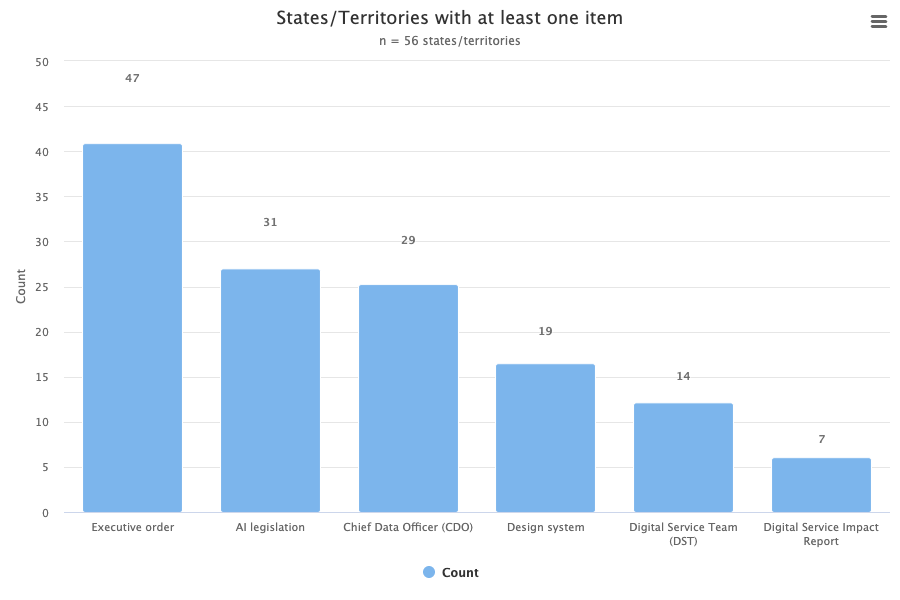

83.9% U.S. states/territories have an executive order.
55.4% U.S. states/territories have AI legislation.
51.8% U.S. states/territories have a chief data office (CDO).
33.9% U.S. states/territories have a design system.
25.0% U.S. states/territories have a digital service team (DST).
12.5% U.S. states/territories have a digital service impact report.

In [ ]:
library(readr); library(here)
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))


# Packages
library(tidyverse)
library(highcharter)
library(htmlwidgets)
library(webshot2)
library(glue)
library(scales)

-   Which **regions** have the most vs least:

    -   Executive order

    -   AI Legislations

    -   Chief Data Officers (CDO)

    -   Digital Service Teams (DST)

    -   Digital Service Impact Reports

    -   Design systems

<!-- -->

-   What is the **distribution of digital transformation activities** by state/territory? (e.g., number of EOs per state)

<!-- -->

-   Which states are the **most active vs. least active** across all categories?

-   Which states introduced CDOs or DSTs earliest, and how has that spread across regions?

-   Which states with **active CDOs** also have **design systems** or **DSTs**?

-   Are states with AI legislation more likely to have other forms of digital infrastructure (DST, design systems)?

-   What are the **most common policy topics** in executive orders (e.g., broadband, interoperability, AI)?

-   What are the **most common policy topics** in AI legislations orders (e.g., broadband, interoperability, AI)?

-   What is the **trend over time** in the number of executive orders and AI legislations enacted?

-   Do **early adopters** (states with policies from 2010–2015) differ from late adopters in 2020–2025?

-   Do states with **higher numbers of executive orders** also pass more legislations or rules?

-   Do states with **impact reports** show evidence of greater adoption of other digital practices?

-   Other ideas: Heatmaps of activity types by state, regional comparisons (Northeast vs. South vs. West), and timelines of adoption by year (EOs, bills, rules).